# Aligning thoughts on predicting EM
The ThinkorSwim platform has a number for a ticker's expected move (EM) during the day. This figure can be used to determine whether price action is normal or abnormal. For example, if the EM for the next day is 20 points, movement outside of this range is abnormal. The expectation is that price will trade within a certain range, and movement outside of it presents opportunity. It's a proprietary figure that ToS produces, and because of its consistent calculation, it can be useful in any system.

However, its interpretability can be very subjective. EM can decrease between days, but it may or may not accurately reflect volatility of price action for the following day.

This model attempts to predict the next day's range based on VIX levels.

In [1]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import yfinance as yf
import json
import requests
from bs4 import BeautifulSoup
from typing import List
import xgboost as xgb
from tqdm import tqdm

# Helper Functions

In [2]:
def walk_forward_validation(df, target_column, num_training_rows, num_periods):
    
    # Create an XGBRegressor model
    model = xgb.XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state = 42)
    
    overall_results = []
    # Iterate over the rows in the DataFrame, one step at a time
    for i in tqdm(range(num_training_rows, df.shape[0] - num_periods + 1)):
        # Split the data into training and test sets
        X_train = df.drop(target_column, axis=1).iloc[:i]
        y_train = df[target_column].iloc[:i]
        X_test = df.drop(target_column, axis=1).iloc[i:i+num_periods]
        y_test = df[target_column].iloc[i:i+num_periods]
        
        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Make a prediction on the test data
        predictions = model.predict(X_test)
        
        # Create a DataFrame to store the true and predicted values
        result_df = pd.DataFrame({'True': y_test, 'Predicted': predictions}, index=y_test.index)
        
        overall_results.append(result_df)

    df_results = pd.concat(overall_results)
    model.save_model('model.bin')
    # Return the true and predicted values, and fitted model
    return df_results, model

def walk_forward_validation_clf(df, target_column, num_training_rows, num_periods):
    
    # Create an XGBRegressor model
    model = xgb.XGBClassifier(n_estimators=100, random_state = 42)
    
    overall_results = []
    # Iterate over the rows in the DataFrame, one step at a time
    for i in tqdm(range(num_training_rows, df.shape[0] - num_periods + 1)):
        # Split the data into training and test sets
        X_train = df.drop(target_column, axis=1).iloc[:i]
        y_train = df[target_column].iloc[:i]
        X_test = df.drop(target_column, axis=1).iloc[i:i+num_periods]
        y_test = df[target_column].iloc[i:i+num_periods]
        
        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Make a prediction on the test data
        predictions = model.predict_proba(X_test)[:,-1]
        
        # Create a DataFrame to store the true and predicted values
        result_df = pd.DataFrame({'True': y_test, 'Predicted': predictions}, index=y_test.index)
        
        overall_results.append(result_df)

    df_results = pd.concat(overall_results)
    model.save_model('model_clf.bin')
    # Return the true and predicted values, and fitted model
    return df_results, model

def walk_forward_validation_clf2(df, target_column, num_training_rows, num_periods):
    
    # Create an XGBRegressor model
    model = xgb.XGBClassifier(n_estimators=100, random_state = 42)
    
    overall_results = []
    # Iterate over the rows in the DataFrame, one step at a time
    for i in tqdm(range(num_training_rows, df.shape[0] - num_periods + 1)):
        # Split the data into training and test sets
        X_train = df.drop(target_column, axis=1).iloc[:i]
        y_train = df[target_column].iloc[:i]
        X_test = df.drop(target_column, axis=1).iloc[i:i+num_periods]
        y_test = df[target_column].iloc[i:i+num_periods]
        
        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Make a prediction on the test data
        predictions = model.predict_proba(X_test)[:,-1]
        
        # Create a DataFrame to store the true and predicted values
        result_df = pd.DataFrame({'True': y_test, 'Predicted': predictions}, index=y_test.index)
        
        overall_results.append(result_df)

    df_results = pd.concat(overall_results)
    model.save_model('model_ensemble.bin')
    # Return the true and predicted values, and fitted model
    return df_results, model

In [3]:
f = open('settings.json')
j = json.load(f)

API_KEY_FRED = j['API_KEY_FRED']

def parse_release_dates(release_id: str) -> List[str]:
    release_dates_url = f'https://api.stlouisfed.org/fred/release/dates?release_id={release_id}&realtime_start=2015-01-01&include_release_dates_with_no_data=true&api_key={API_KEY_FRED}'
    r = requests.get(release_dates_url)
    text = r.text
    soup = BeautifulSoup(text, 'xml')
    dates = []
    for release_date_tag in soup.find_all('release_date', {'release_id': release_id}):
        dates.append(release_date_tag.text)
    return dates

def parse_release_dates_obs(series_id: str) -> List[str]:
    obs_url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&realtime_start=2015-01-01&include_release_dates_with_no_data=true&api_key={API_KEY_FRED}'
    r = requests.get(obs_url)
    text = r.text
    soup = BeautifulSoup(text, 'xml')
    observations  = []
    for observation_tag in soup.find_all('observation'):
        date = observation_tag.get('date')
        value = observation_tag.get('value')
        observations.append((date, value))
    return observations

econ_dfs = {}

econ_tickers = [
    'WALCL',
    'NFCI',
    'WRESBAL'
]

for et in tqdm(econ_tickers, desc='getting econ tickers'):
    # p = parse_release_dates_obs(et)
    # df = pd.DataFrame(columns = ['ds',et], data = p)
    df = pdr.get_data_fred(et)
    df.index = df.index.rename('ds')
    # df.index = pd.to_datetime(df.index.rename('ds')).dt.tz_localize(None)
    # df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)
    econ_dfs[et] = df

# walcl = pd.DataFrame(columns = ['ds','WALCL'], data = p)
# walcl['ds'] = pd.to_datetime(walcl['ds']).dt.tz_localize(None)

# nfci = pd.DataFrame(columns = ['ds','NFCI'], data = p2)
# nfci['ds'] = pd.to_datetime(nfci['ds']).dt.tz_localize(None)

release_ids = [
    "10", # "Consumer Price Index"
    "46", # "Producer Price Index"
    "50", # "Employment Situation"
    "53", # "Gross Domestic Product"
    "103", # "Discount Rate Meeting Minutes"
    "180", # "Unemployment Insurance Weekly Claims Report"
    "194", # "ADP National Employment Report"
    "323" # "Trimmed Mean PCE Inflation Rate"
]

release_names = [
    "CPI",
    "PPI",
    "NFP",
    "GDP",
    "FOMC",
    "UNEMP",
    "ADP",
    "PCE"
]

releases = {}

for rid, n in tqdm(zip(release_ids, release_names), total = len(release_ids), desc='Getting release dates'):
    releases[rid] = {}
    releases[rid]['dates'] = parse_release_dates(rid)
    releases[rid]['name'] = n 

# Create a DF that has all dates with the name of the col as 1
# Once merged on the main dataframe, days with econ events will be 1 or None. Fill NA with 0
# This column serves as the true/false indicator of whether there was economic data released that day.
for rid in tqdm(release_ids, desc='Making indicators'):
    releases[rid]['df'] = pd.DataFrame(
        index=releases[rid]['dates'],
        data={
        releases[rid]['name']: 1
        })
    releases[rid]['df'].index = pd.DatetimeIndex(releases[rid]['df'].index)
    # releases[rid]['df']['ds'] = pd.to_datetime(releases[rid]['df']['ds']).dt.tz_localize(None)
    # releases[rid]['df'] = releases[rid]['df'].set_index('ds')

Making indicators: 100%|██████████| 8/8 [00:00<00:00, 3997.91it/s]


# Data Gathering & Prep

In [4]:
vix = yf.Ticker('^VIX')
spx = yf.Ticker('^GSPC')

prices_vix = vix.history(start='2020-01-01', interval='1d')
prices_spx = spx.history(start='2020-01-01', interval='1d')

In [5]:
prices_spx['index'] = [str(x).split()[0] for x in prices_spx.index]
prices_spx['index'] = pd.to_datetime(prices_spx['index']).dt.date
prices_spx.index = prices_spx['index']
prices_spx = prices_spx.drop(columns='index')

prices_vix['index'] = [str(x).split()[0] for x in prices_vix.index]
prices_vix['index'] = pd.to_datetime(prices_vix['index']).dt.date
prices_vix.index = prices_vix['index']
prices_vix = prices_vix.drop(columns='index')

data = prices_spx.merge(prices_vix[['Open','High','Low','Close']], left_index=True, right_index=True, suffixes=['','_VIX'])
data.index = pd.DatetimeIndex(data.index)

## Feature Development

In [6]:
# Features
data['PrevClose'] = data['Close'].shift(1)
data['Perf5Day'] = data['Close'] > data['Close'].shift(5)
data['Perf5Day_n1'] = data['Perf5Day'].shift(1)
data['Perf5Day_n1'] = data['Perf5Day_n1'].astype(bool)
data['GreenDay'] = (data['Close'] > data['PrevClose']) * 1
data['RedDay'] = (data['Close'] <= data['PrevClose']) * 1
data['ConsecutiveGreen'] = data['GreenDay'].cumsum() * data['GreenDay']

data['VIX5Day'] = data['Close_VIX'] > data['Close_VIX'].shift(5)
data['VIX5Day_n1'] = data['VIX5Day'].astype(bool)

data['Range'] = data[['Open','High']].max(axis=1) - data[['Low','Open']].min(axis=1) # Current day range in points
data['RangePct'] = data['Range'] / data['Close']
data['VIXLevel'] = pd.qcut(data['Close_VIX'], 4)
data['OHLC4_VIX'] = data[['Open_VIX','High_VIX','Low_VIX','Close_VIX']].mean(axis=1)
data['OHLC4'] = data[['Open','High','Low','Close']].mean(axis=1)
data['RangePct_n1'] = data['RangePct'].shift(1)
data['RangePct_n2'] = data['RangePct'].shift(2)
data['OHLC4_VIX_n1'] = data['OHLC4_VIX'].shift(1)
data['OHLC4_VIX_n2'] = data['OHLC4_VIX'].shift(2)
data['CurrentGap'] = (data['Open'] - data['PrevClose']) / data['PrevClose']
data['CurrentGap'] = data['CurrentGap'].shift(-1)
data['DayOfWeek'] = pd.to_datetime(data.index)
data['DayOfWeek'] = data['DayOfWeek'].dt.day

# Target -- the next day's low
data['Target'] = (data['OHLC4'] / data['PrevClose']) - 1
data['Target'] = data['Target'].shift(-1)
# data['Target'] = data['RangePct'].shift(-1)

# Target for clf -- whether tomorrow will close above or below today's close
data['Target_clf'] = data['Close'] > data['PrevClose']
data['Target_clf'] = data['Target_clf'].shift(-1)
data['DayOfWeek'] = pd.to_datetime(data.index)
data['Quarter'] = data['DayOfWeek'].dt.quarter
data['DayOfWeek'] = data['DayOfWeek'].dt.weekday

for rid in tqdm(release_ids, desc='Merging econ data'):
    # Get the name of the release
    n = releases[rid]['name']
    # Merge the corresponding DF of the release
    data = data.merge(releases[rid]['df'], how = 'left', left_index=True, right_index=True)
    # Create a column that shifts the value in the merged column up by 1
    data[f'{n}_shift'] = data[n].shift(-1)
    # Fill the rest with zeroes
    data[n] = data[n].fillna(0)
    data[f'{n}_shift'] = data[f'{n}_shift'].fillna(0)
    
data['BigNewsDay'] = data[[x for x in data.columns if '_shift' in x]].max(axis=1)

Merging econ data: 100%|██████████| 8/8 [00:00<00:00, 799.28it/s]


In [55]:
def cumul_sum(col):
    nums = []
    s = 0
    for x in col:
        if x == 1:
            s += 1
        elif x == 0:
            s = 0
        nums.append(s)
    return nums

consec_green = cumul_sum(data['GreenDay'].values)
consec_red = cumul_sum(data['RedDay'].values)

data['DaysGreen'] = consec_green
data['DaysRed'] = consec_red

In [58]:
max(consec_red)

7

In [57]:
data[['GreenDay','DaysGreen']]

,GreenDay,DaysGreen
index,,
2020-01-02,0,0
2020-01-03,0,0
2020-01-06,1,1
2020-01-07,0,0
2020-01-08,1,1
...,...,...
2023-06-30,1,2
2023-07-03,1,3
2023-07-05,0,0


## Model Data

In [10]:
df_final = data[[
    'BigNewsDay',
    'Quarter',
    'Perf5Day',
    'Perf5Day_n1',
    'DaysGreen',
    'DaysRed',
    # 'VIX5Day',
    # 'VIX5Day_n1',
    'CurrentGap',
    'RangePct',
    'RangePct_n1',
    'RangePct_n2',
    'OHLC4_VIX',
    'OHLC4_VIX_n1',
    'OHLC4_VIX_n2',
    'Target',
    'Target_clf']]
df_final = df_final.dropna(subset=['Target','Target_clf','Perf5Day_n1'])

In [11]:
df_final.drop(columns=['Target_clf']).dtypes

BigNewsDay      float64
Quarter           int64
Perf5Day           bool
Perf5Day_n1        bool
DaysGreen         int64
DaysRed           int64
CurrentGap      float64
RangePct        float64
RangePct_n1     float64
RangePct_n2     float64
OHLC4_VIX       float64
OHLC4_VIX_n1    float64
OHLC4_VIX_n2    float64
Target          float64
dtype: object

# Regression Model

In [12]:
res, xgbr = walk_forward_validation(df_final.drop(columns=['Target_clf']), 'Target', 100, 1)

100%|██████████| 783/783 [00:34<00:00, 22.58it/s]


In [13]:
res

,True,Predicted
index,,
2020-05-27,0.001967,-0.000494
2020-05-28,-0.000137,-0.007602
2020-05-29,0.000902,-0.002683
2020-06-01,0.004532,0.002227
2020-06-02,0.010414,0.001869
...,...,...
2023-06-29,0.009552,0.010378
2023-06-30,0.000185,-0.000360
2023-07-03,-0.002403,-0.003074


In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=res['True'],
                   y_pred=res['Predicted'])

327.2996180937887

In [15]:
mean_absolute_error(y_true=res['True'],
                   y_pred=res['Predicted']) * 100

0.4086047108473844

<AxesSubplot:xlabel='index'>

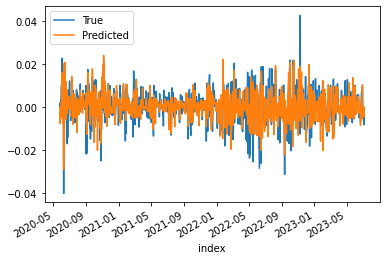

In [16]:
res.plot()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

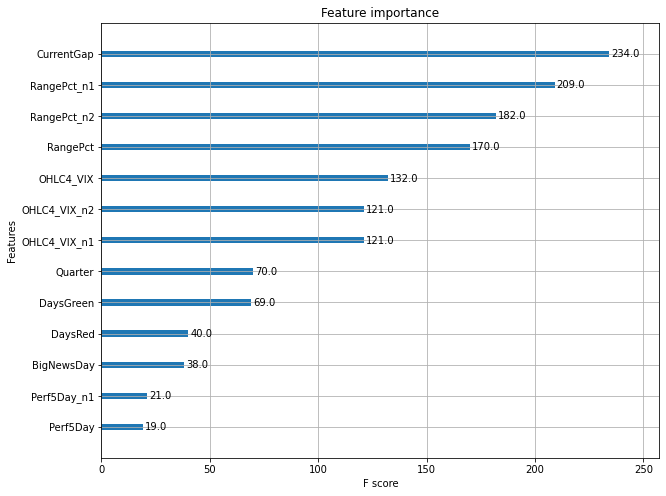

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgbr, importance_type='weight', ax=ax)

In [18]:
np.mean(data['CurrentGap'].abs()>0.0015)

0.6979638009049773

In [19]:
df_compare_reg = df_final.drop(columns=['Target','Target_clf']).merge(res, left_index=True, right_index=True)
df_compare_reg = df_compare_reg.merge(data[['PrevClose','High','Low','Close']], left_index=True, right_index=True)

In [20]:
# How often was the predicted OHLC4 within the current day's range?
df_compare_reg['PredOHLC4'] = df_compare_reg['Predicted'].shift(1)
df_compare_reg['PredOHLC4'] = (1 + df_compare_reg['PredOHLC4']) * df_compare_reg['PrevClose']

In [21]:
df_compare_reg['InRange'] = (df_compare_reg['PredOHLC4'] <= df_compare_reg['High']) & (df_compare_reg['PredOHLC4'] >= df_compare_reg['Low'])

In [22]:
df_compare_reg['InRange'].mean()

0.7982120051085568

In [23]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, PrecisionRecallDisplay

# When the predicted OHLC4 was positive, how often was it a green day?
df_compare_reg['PredDirection'] = df_compare_reg['Predicted'] > 0
# df_compare_reg['PredDirection'] = df_compare_reg['PredDirection'].shift(1)
df_compare_reg['ActualDirection'] = df_compare_reg['Close'] > df_compare_reg['PrevClose']
df_compare_reg['ActualDirection'] = df_compare_reg['ActualDirection'].shift(-1)

In [24]:
df_compare_reg.pivot_table(columns='PredDirection', index='ActualDirection', values='Close', aggfunc='count')

PredDirection,False,True
ActualDirection,,
False,250,123
True,119,290


In [25]:
compare_ohlc4_model = df_compare_reg.dropna(subset=['PredDirection','ActualDirection'])
print(roc_auc_score(compare_ohlc4_model['ActualDirection'].astype(int), compare_ohlc4_model['PredDirection'].astype(int)))
print(precision_score(compare_ohlc4_model['ActualDirection'].astype(int), compare_ohlc4_model['PredDirection'].astype(int)))
print(recall_score(compare_ohlc4_model['ActualDirection'].astype(int), compare_ohlc4_model['PredDirection'].astype(int)))

0.6896438708154985
0.7021791767554479
0.7090464547677262


# Classification Model

In [26]:
res1, xgbc = walk_forward_validation_clf(df_final.drop(columns=['Target']), 'Target_clf', 100, 1)

100%|██████████| 783/783 [00:45<00:00, 17.32it/s]


In [27]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, PrecisionRecallDisplay
print(roc_auc_score(res1['True'].astype(int), res1['Predicted'].values))
print(precision_score(res1['True'].astype(int), res1['Predicted'] > 0.5))
print(recall_score(res1['True'].astype(int), res1['Predicted'] > 0.5))
# print(roc_auc_score(res1['True'].astype(int), res1['Predicted'].values))

0.7140377600251036
0.6564705882352941
0.6821515892420538


In [28]:
res1['True'].mean()

0.5223499361430396

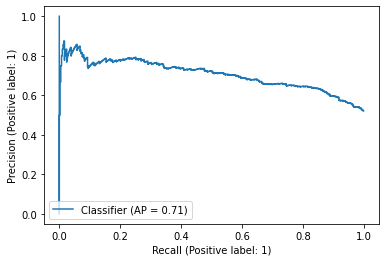

In [29]:
PrecisionRecallDisplay.from_predictions(res1['True'].astype(int), res1['Predicted'].values)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

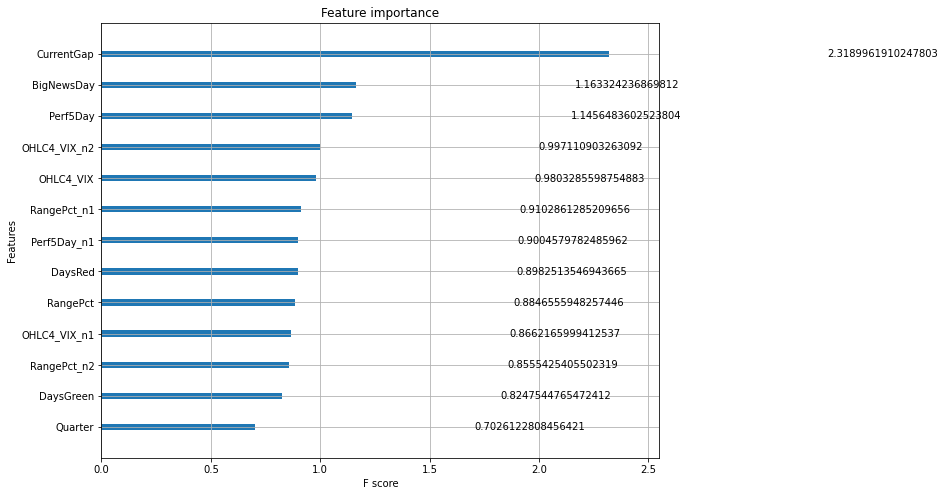

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgbc, importance_type='gain', ax=ax)

In [31]:
df_compare = df_final.drop(columns=['Target','Target_clf']).merge(res1, left_index=True, right_index=True)

# What do these false positives look like?
# false_pos = df_compare.loc[(df_compare['True'] == False) & (df_compare['Predicted'] > 0.5)]

In [32]:
# Label fp, tp, fn, tn
def label_type(actual, pred):
    if actual == True and pred > 0.5:
        return 'TP'
    elif actual == False and pred > 0.5:
        return 'FP'
    elif actual == False and pred <= 0.5:
        return 'TN'
    elif actual == True and pred <= 0.5:
        return 'FN'

df_compare['label_type'] = [label_type(actual, pred) for actual, pred in zip(df_compare['True'],df_compare['Predicted'])]

In [33]:
df_compare.groupby('label_type')['True'].count()

label_type
FN    130
FP    146
TN    228
TP    279
Name: True, dtype: int64

In [34]:
294 / (294 + 147)

0.6666666666666666

In [35]:
227 / (227 + 115)

0.6637426900584795

# New Prediction

In [59]:
# Get last row
new_pred = data[['BigNewsDay',
    'Quarter',
    'Perf5Day',
    'Perf5Day_n1',    
    'DaysGreen',    
    'DaysRed',    
    # 'VIX5Day',
    # 'VIX5Day_n1',
    'CurrentGap',
    'RangePct',
    'RangePct_n1',
    'RangePct_n2',
    'OHLC4_VIX',
    'OHLC4_VIX_n1',
    'OHLC4_VIX_n2']].iloc[-1]

new_pred = pd.DataFrame(new_pred).T

new_pred['BigNewsDay'] = new_pred['BigNewsDay'].astype(float)
new_pred['Quarter'] = new_pred['Quarter'].astype(int)
new_pred['Perf5Day'] = new_pred['Perf5Day'].astype(bool)
new_pred['Perf5Day_n1'] = new_pred['Perf5Day_n1'].astype(bool)
new_pred['DaysGreen'] = new_pred['DaysGreen'].astype(float)
new_pred['DaysRed'] = new_pred['DaysRed'].astype(float)
# new_pred['VIX5Day'] = new_pred['VIX5Day'].astype(bool)
# new_pred['VIX5Day_n1'] = new_pred['VIX5Day_n1'].astype(bool)
new_pred['CurrentGap'] = new_pred['CurrentGap'].astype(float)
new_pred['RangePct'] = new_pred['RangePct'].astype(float)
new_pred['RangePct_n1'] = new_pred['RangePct_n1'].astype(float)
new_pred['RangePct_n2'] = new_pred['RangePct_n2'].astype(float)
new_pred['OHLC4_VIX'] = new_pred['OHLC4_VIX'].astype(float)
new_pred['OHLC4_VIX_n1'] = new_pred['OHLC4_VIX_n1'].astype(float)
new_pred['OHLC4_VIX_n2'] = new_pred['OHLC4_VIX_n2'].astype(float)

# The only variable you can play with as the other ones are historical
new_pred.loc[:,'CurrentGap'] = -20

In [60]:
xgbc.predict_proba(new_pred)[:,-1] > 0.5

array([False])

In [61]:
xgbr.predict(new_pred) > 0

array([False])

In [62]:
df_ensemble = res[['Predicted']].merge(res1[['Predicted','True']], left_index=True, right_index=True)
df_ensemble.columns = ['RegModelOut','ClfModelOut','Target']
df_ensemble['RegModelOut'] = df_ensemble['RegModelOut'] > 0
df_ensemble['RegModelOut_n1'] = df_ensemble['RegModelOut'].shift(1)
df_ensemble['ClfModelOut_n1'] = df_ensemble['ClfModelOut'].shift(1)
df_ensemble['RegModelOut_n2'] = df_ensemble['RegModelOut'].shift(2)
df_ensemble['ClfModelOut_n2'] = df_ensemble['ClfModelOut'].shift(2)

df_ensemble = df_ensemble.dropna(subset=['ClfModelOut_n2'])
df_ensemble['ClfModelOut_tf'] = df_ensemble['ClfModelOut'] > 0.5
df_ensemble.groupby(['RegModelOut','ClfModelOut_tf'])['Target'].mean()

RegModelOut  ClfModelOut_tf
False        False             0.300000
             True              0.402597
True         False             0.636364
             True              0.712644
Name: Target, dtype: float64

In [63]:
df_ensemble[['RegModelOut','ClfModelOut_tf']].value_counts(normalize=True)

RegModelOut  ClfModelOut_tf
True         True              0.445583
False        False             0.371319
             True              0.098592
True         False             0.084507
dtype: float64

# Ensemble the things
Given the performance of these 2 separate models, their combined performance should also (theoretically) be similar. However, looks like more work is going to be needed to improve this model, as its scores did not beat either of the 2 model scores.

In [41]:
df_ensemble['Target'] = df_ensemble['Target'].astype(bool)
df_ensemble['RegModelOut_n1'] = df_ensemble['RegModelOut_n1'].astype(bool)
df_ensemble['RegModelOut_n2'] = df_ensemble['RegModelOut_n2'].astype(bool)

In [42]:
res2, model2 = walk_forward_validation_clf2(df_ensemble, 'Target', 100, 1)

100%|██████████| 681/681 [00:30<00:00, 22.21it/s]


In [43]:
print(roc_auc_score(res2['True'].astype(int), res2['Predicted'].values))
print(precision_score(res2['True'].astype(int), res2['Predicted'] > 0.5))
print(recall_score(res2['True'].astype(int), res2['Predicted'] > 0.5))

0.633531746031746
0.5849056603773585
0.6289855072463768


In [44]:
df_ensemble

,RegModelOut,ClfModelOut,Target,RegModelOut_n1,ClfModelOut_n1,RegModelOut_n2,ClfModelOut_n2,ClfModelOut_tf
index,,,,,,,,
2020-05-29,False,0.050760,True,False,0.080414,False,0.092654,False
2020-06-01,True,0.507086,True,False,0.050760,False,0.080414,True
2020-06-02,True,0.971079,True,True,0.507086,False,0.050760,True
2020-06-03,False,0.158237,False,True,0.971079,True,0.507086,False
2020-06-04,True,0.985288,True,False,0.158237,True,0.971079,True
...,...,...,...,...,...,...,...,...
2023-06-29,True,0.998356,True,True,0.961827,False,0.121329,True
2023-06-30,False,0.395326,True,True,0.998356,True,0.961827,False
2023-07-03,False,0.058706,False,False,0.395326,True,0.998356,False
